This file conducts and exploratory analysis on the magnatuneatag dataset. Here are useful links:
- https://github.com/keunwoochoi/magnatagatune-list?tab=readme-ov-file
- https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from zipfile import ZipFile 
import os
import librosa
from matplotlib import pyplot as plt
import cv2
import json
pd.options.mode.chained_assignment = None  # default='warn'
from imgaug import augmenters as iaa
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1_l2
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import AutoTokenizer
import numpy as np
import json
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from collections import OrderedDict

2024-07-04 19:55:49.264707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 19:55:49.306934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 19:55:49.983324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Importing the embedding model

In [2]:
# import torch
# import torch.nn as nn

# # Define the Encoder class focusing only on the encoding part
# class Encoder(nn.Module):
#     def __init__(self, input_size, encoding_size):
#         super(Encoder, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, 512),
#             nn.ReLU(True),
#             nn.BatchNorm1d(512),
#             nn.Linear(512, 256),
#             nn.ReLU(True),
#             nn.BatchNorm1d(256),
#             nn.Linear(256, 128),
#             nn.ReLU(True),
#             nn.Linear(128, encoding_size),
#             nn.ReLU(True)
#         )

#     def forward(self, x):
#         return self.layers(x)

# # Define input and encoding sizes
# input_size = 768
# encoding_size = 64

# # Instantiate the encoder
# encoder = Encoder(input_size=input_size, encoding_size=encoding_size)

# # Load the pre-trained weights for the encoder
# state_dict = torch.load('/home/mendu/Thesis/data/musiccaps/auto_encoder/encoder_state_dict.pth')

# # Rename the state_dict keys to match the structure of the Encoder class
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     # Prepend 'layers.' to each key
#     name = f'layers.{k}'
#     new_state_dict[name] = v

# # Load the adjusted state_dict into the encoder
# encoder.load_state_dict(new_state_dict)
# encoder.eval()  # Set the encoder to evaluation mode

In [3]:
# roberta_model_path = '/home/mendu/Thesis/data/musiccaps/new_embedding_model'
# roberta_model = SentenceTransformer(roberta_model_path)

In [4]:
# device = torch.device('cuda:0')  # Adjust as needed for your specific GPU device
# encoder.to(device)

In [5]:
# # Input caption
# caption = "This song is jazzy."

# # Encode the caption using RoBERTa model to get a 768 sized vector
# with torch.no_grad():  # Disable gradient calculations for inference
#     roberta_encoded_caption = roberta_model.encode(caption, convert_to_tensor=True)

# roberta_encoded_caption = roberta_encoded_caption.to(device)

# # Now you can pass the input tensor through the encoder
# with torch.no_grad():
#     fully_encoded_caption = encoder(roberta_encoded_caption.unsqueeze(0))

In [6]:
# fully_encoded_caption

I used `cat mp3.zip.* > mp3_all.zip` to concat the 3 compressed folders from the links above and unzip them below

In [7]:
# # loading the zip file and creating a zip object 
# with ZipFile("/home/mendu/Thesis/data/magnatagatune/mp3_all.zip", 'r') as zObject: 
#     zObject.extractall(path="/home/mendu/Thesis/data/magnatagatune/audio") 

I ran `find audio -type f -name "*.mp3" -exec mv {} audio \;` to get all the .mp3 files into the audio folder and
`find audio -type d -empty -delete` to delete the empty folders

In [8]:
# Checking the no. of audio files
audio_dir = '/home/mendu/Thesis/data/magnatagatune/audio'
audio_list = os.listdir(audio_dir)
audio_list = [file_name.replace('.wav.mp3', '') for file_name in audio_list] # list of audio track names
print('Total number of audio files', len(audio_list))

Total number of audio files 25863


In [9]:
#Importing the tags csv file
df = pd.read_csv('/home/mendu/Thesis/data/magnatagatune/tag_annotations.csv',sep = "\t" ,index_col=[0])
df['mp3_path'] = [i[2:] for i in df['mp3_path']] 

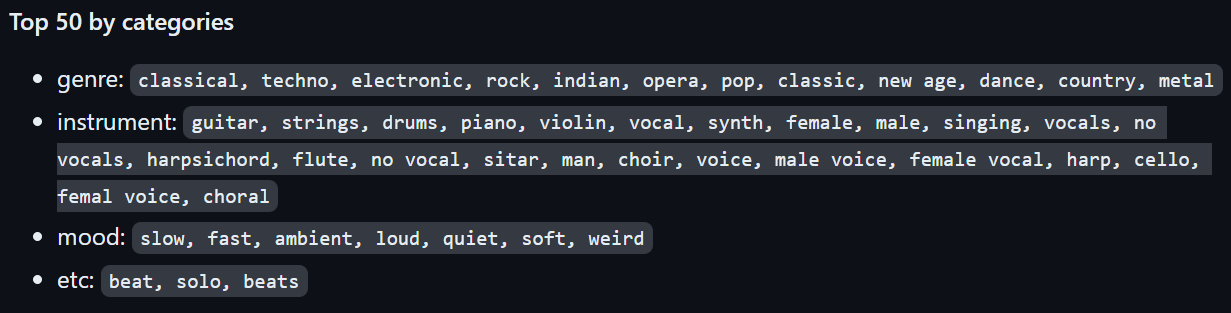

genre: classical, techno, electronic, rock, indian, opera, pop, classic, new age, dance, country, metal

In [10]:
'''genre and synonym_dict for num_class = 8'''
# List of the most frequent genre tags
genre = ['classical', 'clasical', 'classic', 'techno', 'electronic', 'electro', 'electronica', 
 'electric', 'rock', 'indian', 'india', 'opera', 'operatic', 'pop', 'new age', 'dance', 
 'country', 'metal', 'heavy', 'heavy metal']

# Dictionary of genre tags that are synonyms
synonym_dict = {'classical':['classical', 'clasical', 'classic'],
                'electronic': ['electronic', 'electro', 'electronica', 'electric', 'techno', 'dance'],
                'indian': ['indian', 'india'],
                'opera': ['opera', 'operatic'],
                'rock': ['rock', 'metal', 'heavy', 'heavy metal']}

'''genre and synonym_dict for num_class = 10'''
# genre = ['classical', 'clasical', 'classic', 'techno', 'electronic', 'electro', 'electronica', 
#  'electric', 'rock', 'indian', 'india', 'opera', 'operatic', 'pop', 'new age',
#  'country']

# synonym_dict = {'classical':['classical', 'clasical', 'classic'],
#                 'electronic': ['electronic', 'electro', 'electronica', 'electric', 'techno'],
#                 'indian': ['indian', 'india'],
#                 'opera': ['opera', 'operatic'],
#                 'metal': ['metal', 'heavy', 'heavy metal']}


genre.append('mp3_path')

df = df[genre]

In [11]:
df

,classical,clasical,classic,techno,electronic,electro,electronica,electric,rock,indian,...,opera,operatic,pop,new age,dance,country,metal,heavy,heavy metal,mp3_path
clip_id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
6,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
10,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
11,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,american_bach_soloists-j_s__bach_solo_cantatas...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,jacob_heringman-blame_not_my_lute-56-la_bressa...
58906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,jacob_heringman-blame_not_my_lute-57-lost_is_m...
58907,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,jacob_heringman-blame_not_my_lute-57-lost_is_m...


In [12]:
# Creating a single column for all the tags
df['tags'] = df.apply(lambda row: (','.join(row.index[row == 1])).split(','), axis=1)

df = df[['mp3_path', 'tags']]

In [13]:
df

,mp3_path,tags
clip_id,,
2,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, opera]"
6,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, classic, opera]"
10,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, classic, opera]"
11,american_bach_soloists-j_s__bach_solo_cantatas...,[opera]
12,american_bach_soloists-j_s__bach_solo_cantatas...,"[classical, classic]"
...,...,...
58899,jacob_heringman-blame_not_my_lute-56-la_bressa...,[]
58906,jacob_heringman-blame_not_my_lute-57-lost_is_m...,[]
58907,jacob_heringman-blame_not_my_lute-57-lost_is_m...,[classical]


In [14]:
# nested for loop to replace the synonyms
for idx, row in df.iterrows(): #iterates over the rows
    new_tags = []
    for tag in row['tags']: #iterates over each element in the aspect_list list
        for key, values in synonym_dict.items(): #iterates over same_tags dictionary
            if tag in values:
                new_tags.append(key)
                break
        else:
            new_tags.append(tag)
    
    # Making sure the tags are unique in each row        
    new_tags = list(set(new_tags))       
    
    # If multiple tags drop classical if available 
    if len(row['tags'])>1 and 'classical' in row['tags']: #if that are more than one tags and one of it is instrumental drop instrumental
        new_tags.remove('classical')
        
    # updating the tags     
    df.at[idx, 'tags'] = new_tags


# removing empty tags rows
df = df[df['tags'].apply(lambda x: any(x))]

# removing rows with multiple tags
df = df[df['tags'].apply(lambda x: len(x) == 1)].reset_index(drop=True)

# converting the values in the tags column from list to str
df['tags'] = df['tags'].apply(lambda x: x[0])


In [45]:
df

,mp3_path,tags
0,american_bach_soloists-j_s__bach_solo_cantatas...,opera
1,american_bach_soloists-j_s__bach_solo_cantatas...,opera
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera
3,american_bach_soloists-j_s__bach_solo_cantatas...,opera
4,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic
...,...,...
11822,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical
11823,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical
11824,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical
11825,jacob_heringman-blame_not_my_lute-57-lost_is_m...,classical


In [16]:
df.tags.value_counts()

tags
electronic    3279
classical     3191
rock          1751
opera         1259
indian        1234
pop            431
country        354
new age        328
Name: count, dtype: int64

## Generating mel-spectrograms

In [17]:
# Function to convert mp3 files to mel-spectrograms
def mp3_to_melspectrogram(input_folder, output_folder, mp3_name_list):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List to store the names of problematic files
    problematic_files = []

    # Iterate over each file in the input folder
    for filename in mp3_name_list:
        try:
            # Load the audio file
            audio_path = os.path.join(input_folder, filename)
            y, sr = librosa.load(audio_path)

            # Compute the mel-spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

            # Convert to decibel scale
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Save the mel-spectrogram as .npy file
            output_path = os.path.join(output_folder, filename.replace('.mp3', '.npy'))
            np.save(output_path, mel_spectrogram_db)

            # print(f"Mel-spectrogram saved: {output_path}")
        
        except Exception as e:
            # Handle the exception (e.g., skip the file, log the filename)
            print(f"Error processing {filename}: {str(e)}")
            problematic_files.append(filename)

    # Return the list of problematic files
    return problematic_files

        

In [18]:
#generating mel-specs
input_folder = audio_dir
output_folder = '/home/mendu/Thesis/data/magnatagatune/mel-specs'
# mp3_to_melspectrogram(input_folder, output_folder, df.mp3_path.tolist())

In [19]:
len(os.listdir('/home/mendu/Thesis/data/magnatagatune/mel-specs'))

25860

In [20]:
# removing the .mp3 file causing problems
problematic_file = 'jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3'

df = df[df['mp3_path'] != problematic_file]

In [21]:
#Checking if there is a mel-spec for every row in the df
df_filenames = df.mp3_path.apply(lambda x: x[:-4]).tolist()
mel_list = [x[:-4] for x in os.listdir(output_folder)]

if sorted(df_filenames) == sorted(mel_list):
    print('There is a mel_spectrogram for every row in the df.')
else:
    print('Every row in the df doesnt have a mel-spectrogram.')

Every row in the df doesnt have a mel-spectrogram.


In [22]:
# Elements in list1 but not in list2
only_in_df = [x for x in df_filenames if x not in mel_list]

# Elements in list2 but not in list1
only_in_mel = [x for x in mel_list if x not in df_filenames]

print("Elements in df_filenames but not in mel_list:", len(only_in_df))
print("Elements in mel_list but not in df_filenames:", len(only_in_mel))

Elements in df_filenames but not in mel_list: 0
Elements in mel_list but not in df_filenames: 14034


# Training the model

In [23]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [24]:
len(df.mp3_path.to_list())

11826

In [25]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

data = []
i = 0

for filename in audio_names_list: #iterates over the filtered_df audio names
  filename_npy = str(filename[:-4]) + '.npy'
  file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
  img = np.load(file_path)
  data.append(add_gauss_noise(img))

  # To ensure that the files are getting loaded in the correct order
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)

american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-262-291.mp3
american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-291-320.mp3
lvx_nova-lvx_nova-01-contimune-30-59.mp3
american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3
steven_devine-portrait_of_an_english_harpsichord-01-lesson_1_in_g_major_prelude_james_nares-30-59.mp3
the_headroom_project-jetuton_andawai-01-linda_morena-88-117.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-30-59.mp3
american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-146-175.mp3


In [26]:
df.head(10)

,mp3_path,tags
0,american_bach_soloists-j_s__bach_solo_cantatas...,opera
1,american_bach_soloists-j_s__bach_solo_cantatas...,opera
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera
3,american_bach_soloists-j_s__bach_solo_cantatas...,opera
4,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic
5,american_bach_soloists-j_s__bach__cantatas_vol...,classical
6,steven_devine-portrait_of_an_english_harpsicho...,classical
7,the_headroom_project-jetuton_andawai-01-linda_...,pop
8,american_bach_soloists-heinrich_schutz__musica...,opera
9,american_bach_soloists-heinrich_schutz__musica...,opera


In [27]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(11826, 128, 1255)

In [28]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['tags']), test_size=0.1, random_state=42)

In [29]:
data.shape

(11826, 128, 1255, 1)

In [30]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [31]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

8

In [32]:
# l1 and l2 regularization
l2_reg = 0.001
l1_reg = 0.01

# Initialize the model
model = Sequential()

# Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), input_shape=( 128, 1255, 1), use_bias=False))
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))
model.add(BatchNormalization(momentum=0.9))


model.add(Conv2D(64, (3, 3), kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.9))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.9))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.3))

# New convolutional layers
# model.add(Conv2D(256, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))

# model.add(Conv2D(512, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, use_bias=False))
model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.3))

# # Additional Dense layer of size 64
model.add(Dense(64, use_bias=False))
model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3)) 

# Output layer
model.add(Dense(num_classes, activation='softmax'))

adam_opt = Adam(learning_rate=0.0001)
model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/home/mendu/miniconda3/envs/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-07-04 19:56:50.632965: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 1253, 32)  │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 1253, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 417, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 42, 417, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 415, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 40, 415, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 415, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 138, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 138, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 136, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 136, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 136, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 45, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 45, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,211,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,313,896 (8.83 MB)

 Trainable params: 2,313,448 (8.83 MB)

 Non-trainable params: 448 (1.75 KB)

In [33]:
#Fitting the model and early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
rlronp = ReduceLROnPlateau(monitor="val_accuracy", factor=0.75, patience=3, verbose=1)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper, rlronp]
)

Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 107s 316ms/step - accuracy: 0.4334 - loss: 28.5280 - val_accuracy: 0.5841 - val_loss: 18.4078 - learning_rate: 1.0000e-04
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 105s 314ms/step - accuracy: 0.5747 - loss: 15.8371 - val_accuracy: 0.6746 - val_loss: 9.2173 - learning_rate: 1.0000e-04
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 105s 314ms/step - accuracy: 0.6314 - loss: 7.9834 - val_accuracy: 0.6500 - val_loss: 5.2068 - learning_rate: 1.0000e-04
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 105s 314ms/step - accuracy: 0.6584 - loss: 4.7141 - val_accuracy: 0.7396 - val_loss: 3.5572 - learning_rate: 1.0000e-04
Epoch 5/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 104s 314ms/step - accuracy: 0.6996 - loss: 3.4491 - val_accuracy: 0.7210 - val_loss: 3.0067 - learning_rate: 1.0000e-04
Epoch 6/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 105s 314ms/step - accuracy: 0.7065 - loss: 2.8176 - val_accuracy: 0.7253 - val_loss: 2.5824 - learning_rate: 1.0000e-04
Epoch 7/100
333/333 ━━━━━━━━━━━

In [34]:
# Save the entire model as a `.keras` zip archive.
# model.save('/home/mendu/Thesis/data/magnatagatune/saved_models/model_wmaxpool_0.1l2.keras')

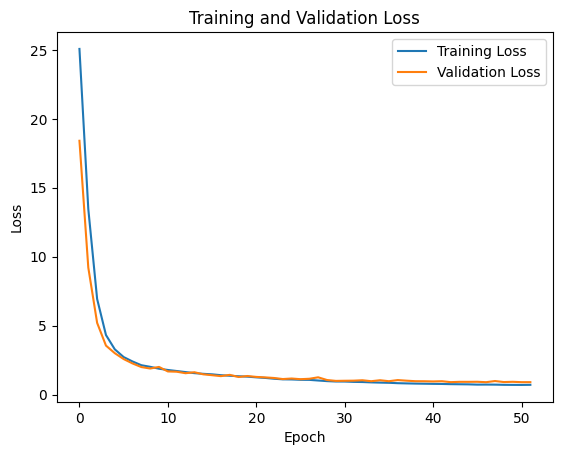

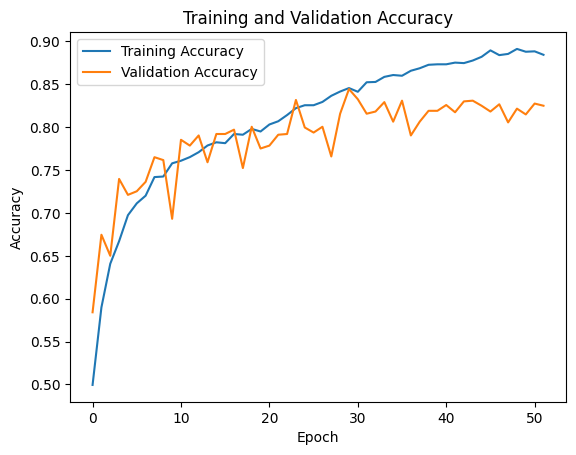

In [35]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
# loss and acc
loss_train, accuracy_train = model.evaluate(X_train, y_train)
print(f'Training Loss: {loss_train}, Training Accuracy: {accuracy_train}')

loss_val, accuracy_val = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss_val}, Validation Accuracy: {accuracy_val}')

333/333 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.9322 - loss: 0.6496
Training Loss: 0.6531542539596558, Training Accuracy: 0.9289674162864685
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8537 - loss: 0.8354
Validation Loss: 0.9057009816169739, Validation Accuracy: 0.8267117738723755


In [42]:
model.save('/home/mendu/Thesis/data/magnatagatune/saved_models/best_baseline.keras')

Try check points savings call back

In [37]:
y_val

,classical,country,electronic,indian,new age,opera,pop,rock
8169,False,False,False,False,False,True,False,False
900,False,False,True,False,False,False,False,False
8075,False,False,False,False,False,False,False,True
7625,True,False,False,False,False,False,False,False
2816,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...
676,True,False,False,False,False,False,False,False
6679,False,False,False,False,False,False,True,False
8882,False,False,False,False,True,False,False,False
3833,False,False,True,False,False,False,False,False


In [38]:
class_labels = ['classical', 'country', 'electronic', 'indian',
               'new age', 'opera', 'pop', 'rock']

predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)  # Converting probabilities to class labels
ground_truth = np.argmax(y_val, axis=1)  # Converting one-hot encoded ground truth to class labels

# Reshape predicted_labels and ground_truth to be 1D arrays
predicted_labels = np.reshape(predicted_labels, (-1,))
ground_truth = np.reshape(ground_truth, (-1,))

predicted_labels = [class_labels[i] for i in predicted_labels]
ground_truth = [class_labels[i] for i in ground_truth]

# Creating a table with prediction and ground truth
comparison_table = pd.DataFrame({'Predicted': predicted_labels, 'Ground Truth': ground_truth})

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

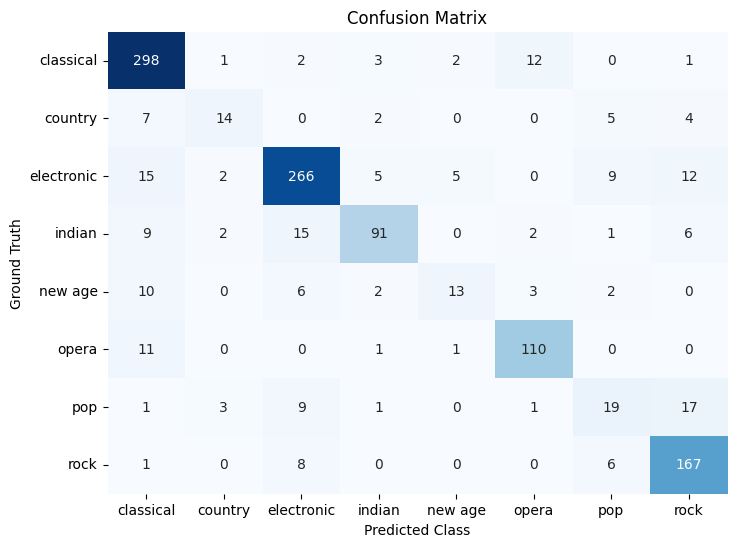

In [40]:
# Get unique class labels
unique_labels = sorted(comparison_table['Ground Truth'].unique())

# Create confusion matrix
conf_matrix = confusion_matrix(comparison_table['Ground Truth'], comparison_table['Predicted'], labels=unique_labels)

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()

In [43]:
X_train

array([[[[0.11372549],
         [0.14901961],
         [0.44705883],
         ...,
         [0.4117647 ],
         [0.40784314],
         [0.12156863]],

        [[0.10196079],
         [0.2784314 ],
         [0.47843137],
         ...,
         [0.43137255],
         [0.3019608 ],
         [0.10588235]],

        [[0.12941177],
         [0.18431373],
         [0.52156866],
         ...,
         [0.40784314],
         [0.34901962],
         [0.14901961]],

        ...,

        [[0.16078432],
         [0.12156863],
         [0.18431373],
         ...,
         [0.14509805],
         [0.15294118],
         [0.09411765]],

        [[0.07843138],
         [0.11372549],
         [0.12941177],
         ...,
         [0.14509805],
         [0.16078432],
         [0.05098039]],

        [[0.13725491],
         [0.11372549],
         [0.1254902 ],
         ...,
         [0.13725491],
         [0.16470589],
         [0.15294118]]],


       [[[0.23529412],
         [0.40784314],
         [0.74

In [41]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from tensorflow.keras.models import Model

# # input_shape=( 128, 1255, 1)
# dummy_input = np.zeros((1, 128, 1255, 1))
# model(dummy_input)

# # Confirm model is built
# model.summary()

# # Now, create a new model that outputs the embeddings from the desired layer
# # Ensure the layer name is correct based on the summary
# # Creating a new model to extract the outputs of the desired layer (last layer in this example)
# latent_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# # Now, you can use this model to predict the train data and retrieve the latent representations
# latent_representations = latent_layer_model.predict(X_train)


# # Now that we have the latent representations, let's reduce their dimensionality for plotting.
# # Apply PCA or t-SNE
# pca = PCA(n_components=2)
# latent_pca_result = pca.fit_transform(latent_representations)

# # You can also apply t-SNE instead of PCA
# # tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# # latent_tsne_result = tsne.fit_transform(latent_representations)

# # Visualize in 2D
# plt.figure(figsize=(8, 6))
# for i in range(num_classes): # Replace num_classes with the actual number
#     indices = np.where(y_train == i)
#     plt.scatter(latent_pca_result[indices, 0], latent_pca_result[indices, 1], label=f'Class {i}')

# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.title('Latent Space Visualization (PCA)')
# plt.legend()
# plt.show()

# # Note: If y_train is one-hot encoded, you need to convert it to single labels first.
# # You can use `y_train_labels = np.argmax(y_train, axis=1)` to get the class labels assuming y_train is one-hot encoded.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 1253, 32)  │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 1253, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 417, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 42, 417, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 415, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 40, 415, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 415, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 138, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 138, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 136, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 136, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 136, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 45, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 45, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,211,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,940,794 (26.48 MB)

 Trainable params: 2,313,448 (8.83 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 4,626,898 (17.65 MB)

ValueError: The layer sequential has never been called and thus has no defined input.

In [ ]:
# Model( output=model.layers[-1].output)

ValueError: Unrecognized keyword arguments passed to Model: {'output': <KerasTensor shape=(None, 8), dtype=float32, sparse=False, name=keras_tensor_351>}

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input

# # Assume you have defined your Sequential model here as 'model'
# # ...

# # Provide the explicit input_shape for the first layer
# # For this example, let's assume your input shape is (128, 128, 3)
# # This input_shape should match the shape of your training data, excluding the batch size

# # Build the model by calling it with dummy data
# dummy_input = np.zeros((1, 128, 128, 3))
# model(dummy_input)

# # Now that the model is built, you can access model.input safely
# print(model.input)


In [ ]:

# tmp_input = dummy_input

# for i, layer in enumerate(model.layers):
#     print(f"Testing layer {i+1}/{len(model.layers)}: {layer.name}")
#     try:
#         # Try to call the layer with the current input and print the output shape
#         tmp_output = layer(tmp_input)
#         print("Output shape:", tmp_output.shape)
#         # Use output as next input
#         tmp_input = tmp_output
#     except ValueError as e:
#         print("ValueError:", e)
#         break

Testing layer 1/26: conv2d
ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 128, 128, 3)
